# Evaluation_2020

$$
\langle T_{ij} \rangle = T_i\cdot \frac{m_i\cdot n_j}{(m_i+s_{ij})(m_i+n_j+s_{ij})}
$$
in which:
$$
T_i=\sum_{j\neq i}T_{ij}
$$
and $\langle T_{ij} \rangle$ means tha mean value of $T_{ij}$ within a period of time. 

In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

In [41]:
path = '/Users/paw_paw/Library/Mobile Documents/com~apple~CloudDocs/学习/PC5287_M.SC Coursework Thesis for Physics And Technology/data set'

In [42]:
Prediction = pd.read_csv(path+'/Prediction2020_gpr.csv')
Prediction.set_index('PA_name',inplace=True)
#Prediction.mask(Prediction==0,np.nan,inplace=True)

In [43]:
flux=pd.read_csv(path+'/Total_flux_ij_2020.csv',index_col='PA_name')

# Evaluation

## Creat the graph

### Delete useless data 

In [105]:
# Replace infinities with nan so that they wont show in the graph

pre = Prediction.replace([np.inf, -np.inf], np.nan, inplace=False)
true = flux.replace([np.inf, -np.inf], np.nan, inplace=False)

In [106]:
# Define a function to delete the palces missing in the population density

empty_pa= ['CENTRAL WATER CATCHMENT',\
               'LIM CHU KANG',\
               'NORTH-EASTERN ISLANDS',\
               'SIMPANG',\
               'SOUTHERN ISLANDS',\
               'MARINA EAST',\
               'CHANGI BAY']

def erase_pa(pa_list,df):
    for pa in pa_list:
        try:
            df=df.drop(columns=pa)[df.index!=pa]
        except KeyError:
            pass
    
    return df

# Also define a function to delete the diagram of the matrix 

def remove_diag(x):
    for i in range(0,pre.shape[0]):
        x.iat[i,i]=None
    return x

In [107]:
pre = erase_pa(empty_pa,pre)
true = erase_pa(empty_pa,true)

pre=remove_diag(pre)
true=remove_diag(true)

### Perform the heatmap

/Users/paw_paw/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


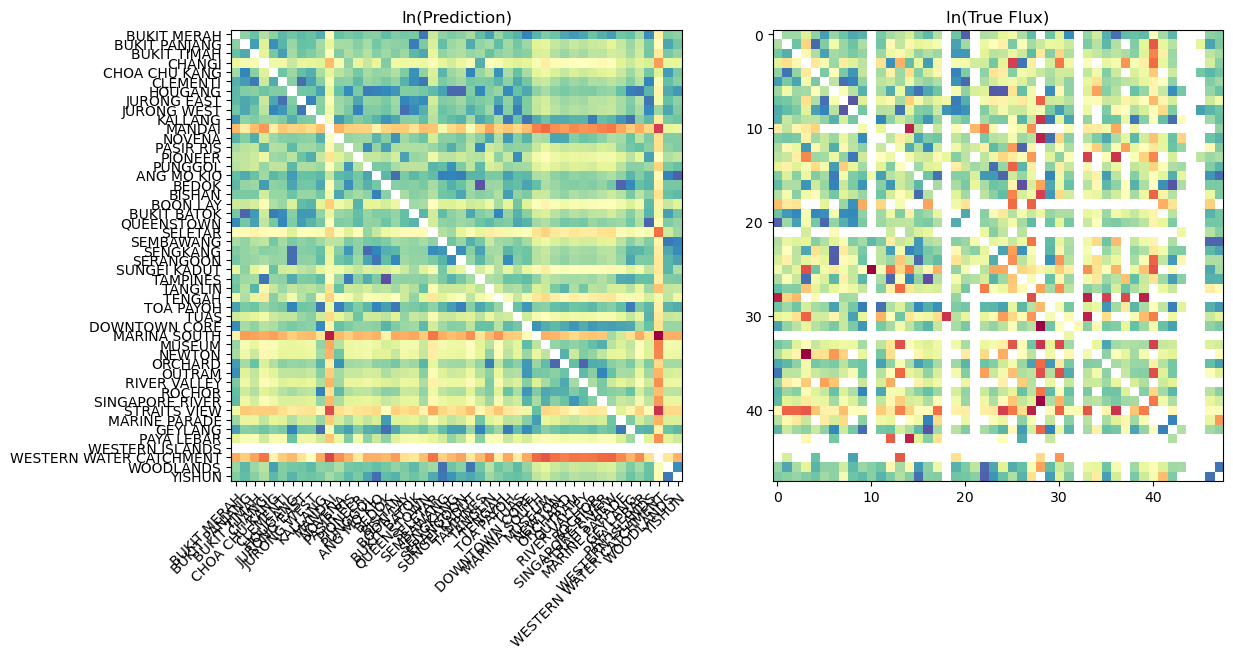

In [108]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches([12.8,9.6])


ax[0].imshow(np.log(pre), cmap='Spectral', interpolation='nearest')
ax[0].set(xticks=np.arange(pre.shape[0]), xticklabels=pre.index,\
          yticks=np.arange(pre.shape[1]), yticklabels=pre.columns ,\
          title='ln(Prediction)',autoscale_on=True)

plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax[1].imshow(np.log(true), cmap='Spectral', interpolation='nearest')
ax[1].set(title='ln(True Flux)')

fig.savefig(path+'/Prediction_2019.png')

plt.show()

### Perform the scatter plot

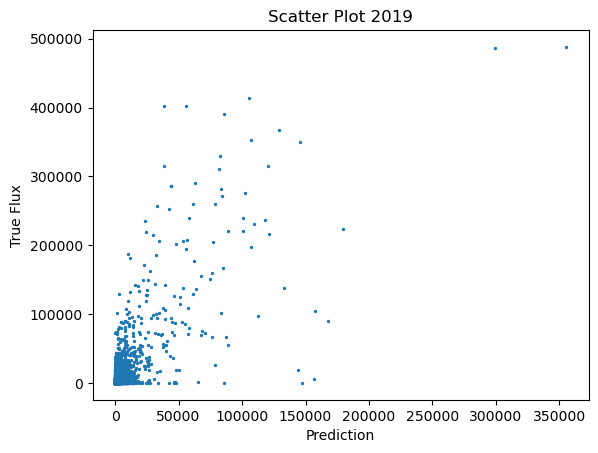

In [75]:
#Scatter plot 
plt.scatter(pre,true,s=2)
plt.xlabel('Prediction')
plt.ylabel('True Flux')
plt.title('Scatter Plot 2019')

# To show the plot
plt.show()

## Improvement and Metrics To Evaluate

### Imputation

In [29]:
from numpy import NaN,Inf

#### impute with geographically k-nearest neighbors

In [109]:
#read KML file
import fiona 

fiona.supported_drivers['KML'] = 'rw'

pa = gpd.read_file(path+'/master-plan-2019-planning-area-boundary-no-sea/planning-boundary-area.kml', \
                            driver='KML')
pa = pa.to_crs(3414)

def extract_desc_pa(desc_pa):
    return desc_pa.split('PLN_AREA_N')[1].split('<td>')[1].split('<')[0]

pa['PLN_AREA_N'] = pa.Description.apply(extract_desc_pa)

pa['centroid'] = pa.centroid

pa_centroid=pa.set_index(['PLN_AREA_N'])['centroid'].to_dict()

In [110]:
# Generate a dataframe to store the r_ij data, and delete the empty PAs too
def r_ij(pa_i, pa_j):
    return pa_centroid.get(pa_i).distance(pa_centroid.get(pa_j))

r_ij_df=pd.DataFrame(columns=pa['PLN_AREA_N'].values,index=pa['PLN_AREA_N'].values)

for i in r_ij_df.index:
    for j in r_ij_df.columns: 
        r_ij_df[i][j]=r_ij(i,j)

r_ij_df = erase_pa(empty_pa,r_ij_df)

In [111]:
def near_mean(pa_i,pa_j,df,k):
    #find the mean value of the flux from the k-neighbors of i to j, based on df(prediction or true value)
    
    neighbors=r_ij_df[pa_i].sort_values().iloc[1:k+1].index.values

    neighbors_flux = np.zeros(k)
    
    for i in range(0,k):
        neighbors_flux[i]=df[pa_j][neighbors[i]]
    return np.nanmean(neighbors_flux)

In [112]:
def impute(df,k):
    for pa_i in df.index:
        for pa_j in df.columns:
            if pd.isna(df[pa_j][pa_i]) and pa_j!=pa_i:
                df[pa_j][pa_i]=near_mean(pa_i,pa_j,df,k)
    return df

In [113]:
k=3

In [114]:
pre.replace([0], np.nan, inplace=True)
true.replace([0], np.nan, inplace=True)
impute(pre,k);impute(true,k)

/var/folders/zy/v_jx4f3s485gxnp_qn6_qjw40000gn/T/ipykernel_29109/718431030.py:10: RuntimeWarning: Mean of empty slice
  return np.nanmean(neighbors_flux)


,BUKIT MERAH,BUKIT PANJANG,BUKIT TIMAH,CHANGI,CHOA CHU KANG,CLEMENTI,HOUGANG,JURONG EAST,JURONG WEST,KALLANG,...,ROCHOR,SINGAPORE RIVER,STRAITS VIEW,MARINE PARADE,GEYLANG,PAYA LEBAR,WESTERN ISLANDS,WESTERN WATER CATCHMENT,WOODLANDS,YISHUN
PA_name,,,,,,,,,,,,,,,,,,,,,
BUKIT MERAH,NaN,12257.000000,12169.000000,2934.000000,15218.000000,78120.000000,13760.000000,31499.000000,61980.000000,49220.000000,...,33713.000000,41113.000000,751.000000,10189.000000,46129.000000,NaN,NaN,NaN,16542.000000,20268.000000
BUKIT PANJANG,8887.000000,NaN,31116.000000,140.000000,256332.000000,20654.000000,1351.000000,13106.000000,32202.000000,8646.000000,...,20907.000000,2546.000000,8.000000,2086.000000,7230.000000,NaN,NaN,2436.000000,68816.000000,23358.000000
BUKIT TIMAH,25642.000000,51456.000000,NaN,494.000000,8919.000000,71774.000000,10622.000000,13273.000000,23026.000000,14299.000000,...,17996.000000,2788.000000,22.000000,363.000000,12856.000000,NaN,NaN,2436.000000,6126.000000,10298.000000
CHANGI,2745.000000,179.000000,492.000000,NaN,284.000000,1096.000000,12516.000000,340.000000,3064.000000,6326.000000,...,1014.000000,374.000000,13.000000,2194.000000,11530.000000,13525.333333,NaN,NaN,3760.000000,17736.000000
CHOA CHU KANG,15769.000000,201206.000000,14385.000000,289.000000,NaN,23603.000000,734.000000,24736.000000,93876.000000,5573.000000,...,3348.000000,1664.000000,109.000000,2086.000000,4411.000000,NaN,NaN,27557.000000,42727.000000,28685.000000
CLEMENTI,82008.000000,24133.000000,67140.000000,1174.000000,24100.000000,NaN,6084.000000,215717.000000,140805.000000,14675.000000,...,5055.000000,2306.000000,454.000000,730.000000,16311.000000,NaN,NaN,2436.000000,19679.000000,11909.000000
HOUGANG,12265.000000,1445.000000,11741.000000,10795.000000,743.000000,6334.000000,NaN,884.000000,7238.000000,49197.000000,...,32608.000000,13632.000000,441.000000,5007.000000,108640.000000,25352.000000,NaN,NaN,14132.000000,31605.000000
JURONG EAST,31046.000000,26094.000000,14426.000000,203.000000,8800.000000,220542.000000,1050.000000,NaN,401700.000000,3014.000000,...,1977.000000,696.000000,72.000000,469.000000,3764.000000,NaN,NaN,36956.000000,4585.000000,1430.000000
JURONG WEST,58753.000000,38731.000000,24720.000000,2800.000000,74333.000000,149707.000000,7269.000000,390356.000000,NaN,25414.000000,...,7844.000000,3468.000000,841.000000,168.000000,22412.000000,NaN,NaN,71476.000000,45589.000000,29350.000000


#### filling the missing data with KNN

#### Metrics
transform the data into an 1-D array and simply delete the missing data in both arrays 

In [115]:
from sklearn.metrics import r2_score,explained_variance_score,mean_absolute_percentage_error

In [116]:
pre.replace([0], np.nan, inplace=True)
true.replace([0], np.nan, inplace=True)

In [117]:
X1=pre.to_numpy().flatten()
X2=true.to_numpy().flatten()

while sum(np.isnan(X1))>0:
    try:
        for i in range(0,X1.size):
            if np.isnan(X1[i]) or np.isnan(X2[i]):
                X1=np.delete(X1,[i])
                X2=np.delete(X2,[i])
    except IndexError:
        continue

print(r2_score(X2,X1),explained_variance_score(X2,X1),mean_absolute_percentage_error(X2,X1))

0.3501512959675597 0.4397042247786149 4.899908690339026


In [48]:
import matplotlib.lines as lines

[1.74209028]


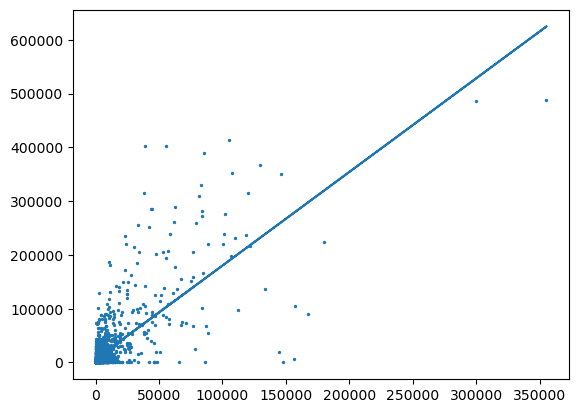

In [76]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X1.reshape(-1,1),X2)
coef=reg.coef_
print(coef)
plt.scatter(X1,X2,s=2)
plt.plot(X1,reg.predict(X1.reshape(-1,1)))